In [1]:
%pip install datasets

In [2]:
# Load data from Hugging Face
from datasets import load_dataset
dataset = load_dataset("maartengr/arxiv_nlp")["train"]

# Extract metadata
abstracts = dataset["Abstracts"]
titles = dataset["Titles"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Embedding Documents

In [3]:
%pip install sentence_transformers

In [4]:
from sentence_transformers import SentenceTransformer

# Create an embedding for each abstract
embedding_model = SentenceTransformer("thenlper/gte-small")
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

Batches:   0%|          | 0/1405 [00:00<?, ?it/s]

In [5]:
# Check the dimensions of the resulting embeddings
embeddings.shape

(44949, 384)

Reducing the Dimensionality of Embeddings

In [6]:
%pip install umap-learn

In [7]:
from umap import UMAP

# We reduce the input embeddings from 384 dimensions to 5 dimensions
umap_model = UMAP(
    n_components=5, min_dist=0.0, metric='cosine', random_state=42
)
reduced_embeddings = umap_model.fit_transform(embeddings)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Cluster the Reduced Embeddings

In [8]:
%pip install hdbscan

In [9]:
from hdbscan import HDBSCAN

# We fit the model and extract the clusters
hdbscan_model = HDBSCAN(
    min_cluster_size=50, metric="euclidean", cluster_selection_method="eom"
).fit(reduced_embeddings)

clusters = hdbscan_model.labels_

# How many clusters did we generate?
len(set(clusters))

148

Inspecting the Clusters

In [10]:
import numpy as np

# Print first three documents in cluster 0
cluster = 0
for index in np.where(clusters == cluster)[0][:3]:
  print(abstracts[index][:300] + "... \n")

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo... 

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang... 

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation systems ignore many aspects when they
generate animation; therefore the interpretation lost the truth inf... 



In [11]:
import pandas as pd

# Reduce 384-dimensional embeddings to two dimensions for easier visualization
reduced_embeddings = UMAP(
    n_components=2, min_dist=0.0, metric="cosine", random_state=42
).fit_transform(embeddings)

# Create dataframe
df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["title"] = titles
df["cluster"] = [str(c) for c in clusters]

# Select outliers and non-outliers (clusters)
clusters_df = df.loc[df.cluster != "-1", :]
outliers_df = df.loc[df.cluster == "-1", :]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(-7.784396243095398,
 11.759053778648376,
 -0.7459853870794177,
 16.086435334943236)

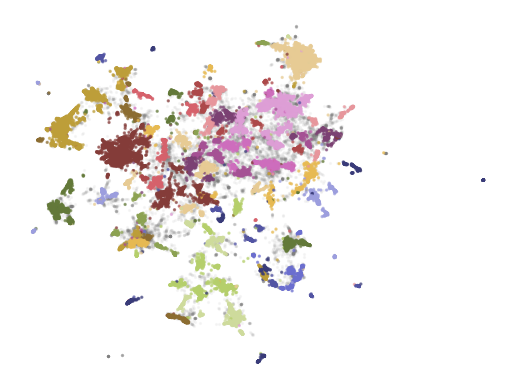

In [12]:
import matplotlib.pyplot as plt

# Plot outliers and non-outliers separately
plt.scatter(outliers_df.x, outliers_df.y, alpha=0.05, s=2, c="grey")
plt.scatter(
    clusters_df.x, clusters_df.y, c=clusters_df.cluster.astype(int), alpha=0.6, s=2, cmap="tab20b"
)
plt.axis("off")

BERTopic: A Modular Topic Modeling Framework

In [13]:
%pip install openai

In [14]:
%pip install datamapplot

In [15]:
%pip install bertopic

  Using cached bertopic-0.16.4-py3-none-any.whl.metadata (23 kB)
Using cached bertopic-0.16.4-py3-none-any.whl (143 kB)


In [16]:
from bertopic import BERTopic

# Train our model with our previously defined models
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
).fit(abstracts, embeddings)

2024-10-28 15:46:29,644 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-10-28 15:48:08,598 - BERTopic - Dimensionality - Completed ✓
2024-10-28 15:48:08,602 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-10-28 15:48:10,548 - BERTopic - Cluster - Completed ✓
2024-10-28 15:48:10,562 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-10-28 15:48:15,806 - BERTopic - Representation - Completed ✓


In [17]:
topic_model.get_topic_info()

Topic  Count                                           Name  \
0       -1  13888                               -1_the_of_and_to   
1        0   2266                 0_question_questions_answer_qa   
2        1   2148                   1_speech_asr_recognition_end   
3        2   1501          2_medical_clinical_biomedical_patient   
4        3   1043                 3_translation_nmt_machine_bleu   
..     ...    ...                                            ...   
143    142     55  142_counterfactual_counterfactuals_cad_causal   
144    143     54           143_emoji_emojis_emoticons_sentiment   
145    144     53      144_prompt_prompts_optimization_prompting   
146    145     52                145_mixed_code_sentiment_mixing   
147    146     51   146_diffusion_generation_autoregressive_text   

                                        Representation  \
0    [the, of, and, to, in, we, for, language, that...   
1    [question, questions, answer, qa, answering, a...   
2    [speech, asr, recognition, end, acoustic, spea...   
3    [medical, clinical, biomedical, patient, healt...   
4    [translation, nmt, machine, bleu, neural, engl...   
..                                                 ...   
143  [counterfactual, counterfactuals, cad, causal,...   
144  [emoji, emojis, emoticons, sentiment, twitter,...   
145  [prompt, prompts, optimization, prompting, llm...   
146  [mixed, code, sentiment, mixing, analysis, eng...   
147  [diffusion, generation, autoregressive, text, ...   

                                   Representative_Docs  
0    [  Understanding context is key to understandi...  
1    [  Neural network models recently proposed for...  
2    [  We describe a method to jointly pre-train s...  
3    [  A common practice in the medical industry i...  
4    [  In this paper, we introduce a hybrid search...  
..                                                 ...  
143  [  For text classification tasks, finetuned la...  
144  [  The frequent use of Emojis on social media ...  
145  [  Prompt optimization aims to find the best p...  
146  [  The usage of more than one language in the ...  
147  [  Diffusion models have achieved great succes...  

[148 rows x 5 columns]

In [18]:
topic_model.get_topic(0)

[('question', 0.021637400575892987),
 ('questions', 0.016266042013288344),
 ('answer', 0.015973519718882438),
 ('qa', 0.015948770268401483),
 ('answering', 0.015063928712626988),
 ('answers', 0.009981543465719056),
 ('retrieval', 0.00936324897726126),
 ('comprehension', 0.0077706581485717),
 ('reading', 0.007173715631069418),
 ('the', 0.00645281722389036)]

In [19]:
topic_model.find_topics("topic modeling")

([19, -1, 2, 28, 37], [0.9542535, 0.91147697, 0.9082159, 0.9078437, 0.9051397])

In [20]:
topic_model.get_topic(19)

[('topic', 0.0673347593468192),
 ('topics', 0.03540285836845324),
 ('lda', 0.01581653492781683),
 ('latent', 0.013186936948642175),
 ('documents', 0.01277143184623727),
 ('document', 0.01245445053285126),
 ('modeling', 0.011878300466914155),
 ('dirichlet', 0.009642634860747127),
 ('clustering', 0.008502740192963742),
 ('word', 0.00846694033929125)]

In [21]:
topic_model.topics_[titles.index("BERTopic: Neural topic modeling with a class-based TF-IDF procedure")]

19

In [22]:
# Visulaize topics and documents
fig = topic_model.visualize_documents(
    titles,
    reduced_embeddings=reduced_embeddings,
    width=1200,
    hide_annotations=True
)

# Update fonts of legend for easier visualization
fig.update_layout(font=dict(size=16))

In [23]:
# Visualize barchart with ranked keywords
topic_model.visualize_barchart()

In [24]:
# Visualize relationships between topics
topic_model.visualize_heatmap(n_clusters=30)

In [25]:
# Visualize the potential hierarchical structure of topics
topic_model.visualize_hierarchy()

Adding a Special Lego Block

In [26]:
# Save original representations
from copy import deepcopy
original_topics = deepcopy(topic_model.topic_representations_)

In [27]:
def topic_differences(model, original_topics, nr_topics=5):
  """Show the differences in topic representations between two models"""
  df = pd.DataFrame(columns=["Topic", "Original", "Updated"])
  for topic in range(nr_topics):
    # Extract top 5 words per topic per model
    og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5])
    new_words = " | ".join(list(zip(*model.get_topic(topic)))[0][:5])
    df.loc[len(df)] = [topic, og_words, new_words]
  return df

KeyBERTInspired

In [28]:
from bertopic.representation import KeyBERTInspired

# Update our topic representations using KeyBERTInspired
representation_model = KeyBERTInspired()
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0     question | questions | answer | qa | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2  medical | clinical | biomedical | patient | he...   
3      3        translation | nmt | machine | bleu | neural   
4      4  summarization | summaries | summary | abstract...   

                                             Updated  
0  answering | questions | answer | comprehension...  
1  phonetic | speech | encoder | language | trans...  
2               nlp | clinical | ehr | ehrs | corpus  
3  translation | translate | translated | transla...  
4  summarization | summarizers | summaries | summ...

Maximal marginal relevance

In [29]:
from bertopic.representation import MaximalMarginalRelevance

# Update our topic representations to MaximalMarginalRelevance
representation_model = MaximalMarginalRelevance(diversity=0.2)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0     question | questions | answer | qa | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2  medical | clinical | biomedical | patient | he...   
3      3        translation | nmt | machine | bleu | neural   
4      4  summarization | summaries | summary | abstract...   

                                             Updated  
0  questions | retrieval | comprehension | knowle...  
1                 speech | asr | audio | wer | error  
2  medical | clinical | biomedical | patient | pa...  
3       translation | nmt | bleu | neural | parallel  
4  summarization | summaries | abstractive | sent...

The Text Generation Lego Block

In [30]:
from transformers import pipeline
from bertopic.representation import TextGeneration

prompt = """I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords:
'[KEYWORDS]'.

Based on the documents and keywords, what is this topic about?"""

# Update our topic representations using Flan-T5
generator = pipeline("text2text-generation", model="google/flan-t5-small")
representation_model = TextGeneration(
    generator, prompt=prompt, doc_length=50, tokenizer="whitespace"
)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
100%|██████████| 148/148 [01:03<00:00,  2.34it/s]


Topic                                           Original  \
0      0     question | questions | answer | qa | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2  medical | clinical | biomedical | patient | he...   
3      3        translation | nmt | machine | bleu | neural   
4      4  summarization | summaries | summary | abstract...   

                                  Updated  
0          Question Answering |  |  |  |   
1          Speech recognition |  |  |  |   
2                Science/Tech |  |  |  |   
3  Neural Machine Translation |  |  |  |   
4               Summarization |  |  |  |

In [31]:
import openai
from bertopic.representation import OpenAI
from google.colab import userdata

prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords:
[KEYWORDS]

Based on the information above, extract a short topic label in the following format:
topic: <short topic label>
"""

# Update our topic representations using GPT-3.5
client = openai.OpenAI(api_key=userdata.get('openAIAPIKey'))
representation_model = OpenAI(
  client, model="gpt-3.5-turbo", exponential_backoff=True, chat=True, prompt=prompt
)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

100%|██████████| 148/148 [01:31<00:00,  1.62it/s]


Topic                                           Original  \
0      0     question | questions | answer | qa | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2  medical | clinical | biomedical | patient | he...   
3      3        translation | nmt | machine | bleu | neural   
4      4  summarization | summaries | summary | abstract...   

                                             Updated  
0  Improving Question Answering with Unsupervised...  
1  Advances in End-to-End Automatic Speech Recogn...  
2  Advanced Approaches in Biomedical Named Entity...  
3  Improving Neural Machine Translation with Vari...  
4  Effectiveness of Summarization Evaluation Metr...

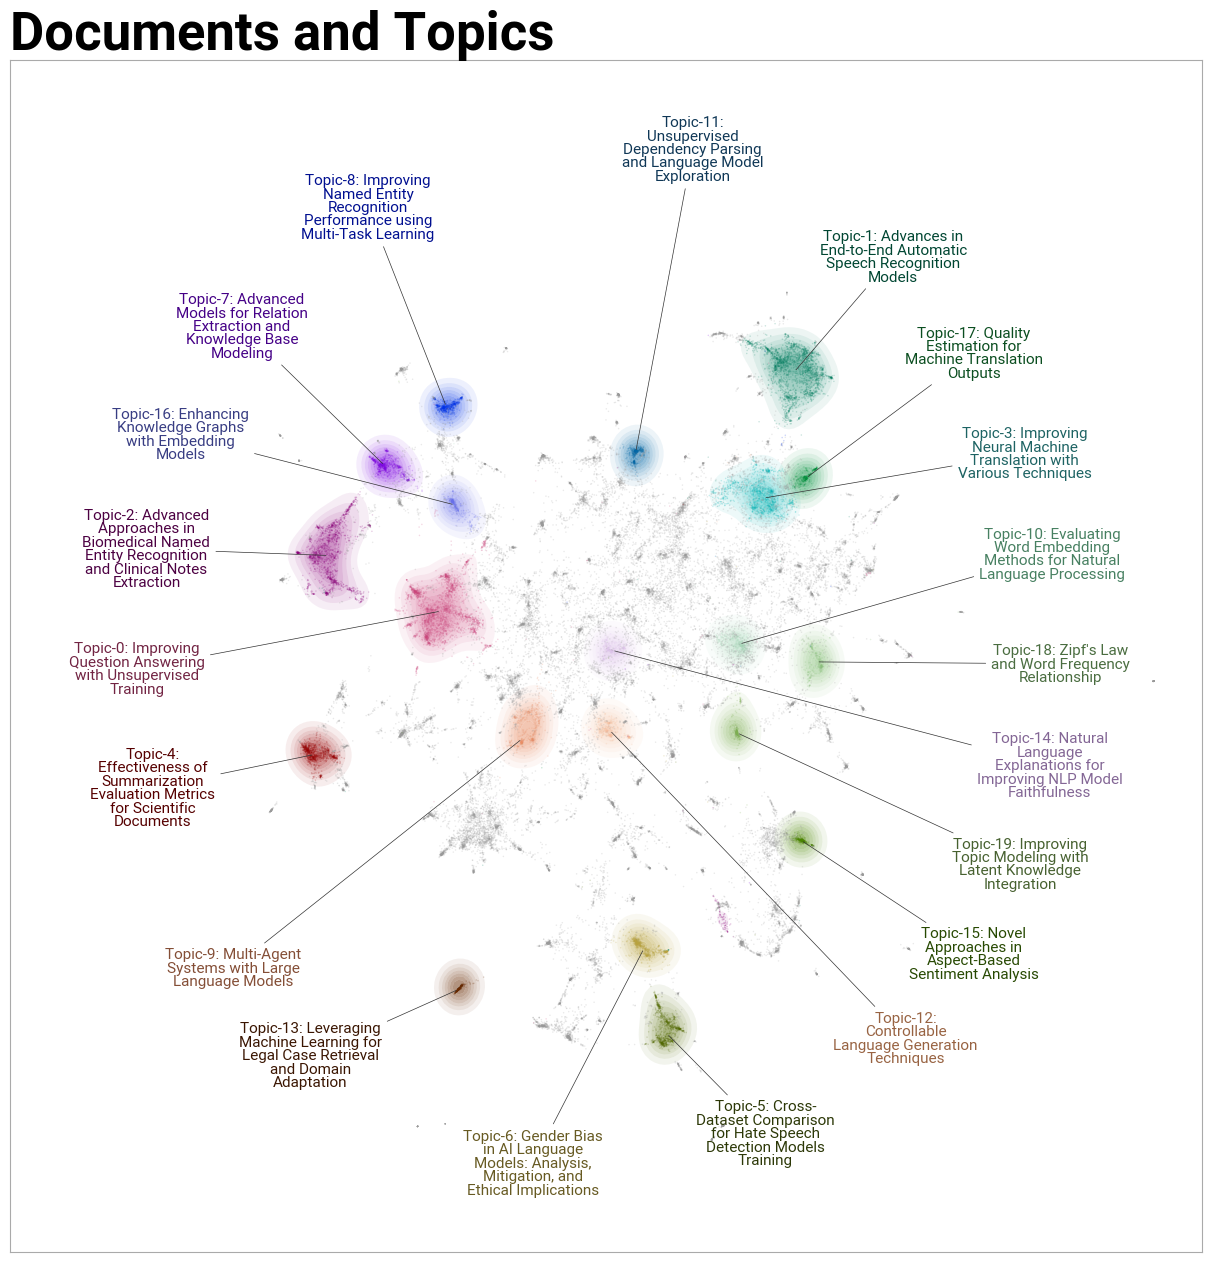

In [32]:
# Visualize topics and documents
fig = topic_model.visualize_document_datamap(
    titles,
    topics=list(range(20)),
    reduced_embeddings=reduced_embeddings,
    width=1200,
    label_font_size=11,
    label_wrap_width=20,
    use_medoids=True,
)